Two types of dataset ['movie_ratings' & 'titanic-machine-learning-from-disaster'] has been used for 2 different task. Explatory Data Analysis has been done for both the dtasets.

#### PySpark Installation

In [64]:
!pip install pyspark

#### Relevant Libraries

In [65]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import random
import os

from pyspark.sql import SparkSession 
from pyspark.ml  import Pipeline     
from pyspark.sql import SQLContext  
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

# Task I.1: Exploratory Data Analysis

## Movie Ratings Dataset

In [66]:
#Creating sparkSession and DataLoading
sparkmv = SparkSession.builder.appName('recommender_system').getOrCreate()
dfmv=sparkmv.read.csv('../input/movie-ratings/movie_rating.csv',inferSchema=True,header=True)

dfmv.limit(5).toPandas()
#df.head(5)

,critic,title,rating
0,Jack Matthews,Lady in the Water,3.0
1,Jack Matthews,Snakes on a Plane,4.0
2,Jack Matthews,You Me and Dupree,3.5
3,Jack Matthews,Superman Returns,5.0
4,Jack Matthews,The Night Listener,3.0


In [67]:
dfmv.printSchema()

root
 |-- critic: string (nullable = true)
 |-- title: string (nullable = true)
 |-- rating: double (nullable = true)



In [68]:
#Converting into Pandas DataFrame
pandas_dfmv = dfmv.toPandas()

pandas_dfmv.shape

(31, 3)

In [69]:
from pyspark.ml.feature import StringIndexer, IndexToString
stringIndexer = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(dfmv) for column in list(set(dfmv.columns)-set(['rating'])) ]

pipeline = Pipeline(stages=stringIndexer)
#fit the pipeline to our dataframe
pipelineModel = pipeline.fit(dfmv)
df_mv = pipeline.fit(dfmv).transform(dfmv)

df_mv.show(5)

+-------------+------------------+------+-----------+------------+
|       critic|             title|rating|title_index|critic_index|
+-------------+------------------+------+-----------+------------+
|Jack Matthews| Lady in the Water|   3.0|        5.0|         4.0|
|Jack Matthews| Snakes on a Plane|   4.0|        0.0|         4.0|
|Jack Matthews| You Me and Dupree|   3.5|        2.0|         4.0|
|Jack Matthews|  Superman Returns|   5.0|        1.0|         4.0|
|Jack Matthews|The Night Listener|   3.0|        3.0|         4.0|
+-------------+------------------+------+-----------+------------+
only showing top 5 rows



#### Critics Movie Rating Scenario

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


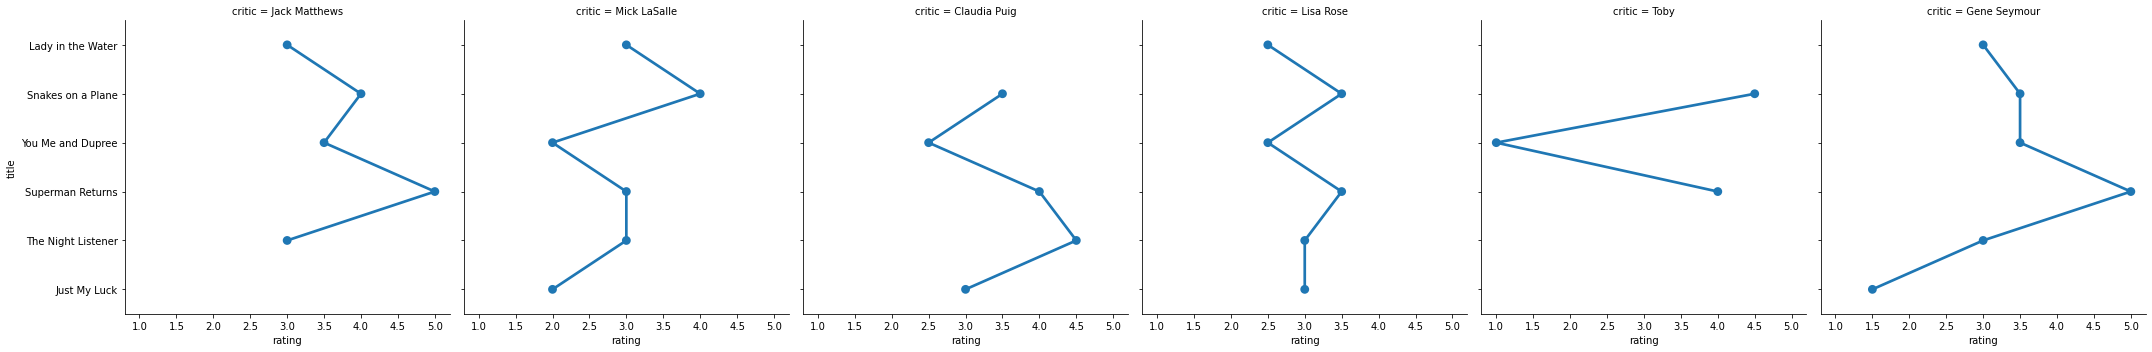

In [70]:
sns.factorplot('rating','title',col='critic',data=pandas_dfmv)
plt.show()

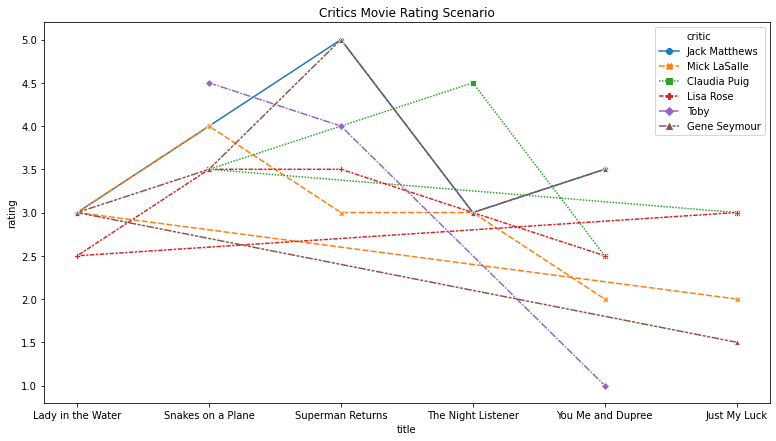

In [71]:
plt.figure(figsize=(13,7))
plt.title('Critics Movie Rating Scenario')
sns.lineplot(x = "title", y = "rating", data=pandas_dfmv, hue="critic",style='critic',markers=True,sort=True)
plt.show()

## Titanic Dataset

In [72]:
#Creating sparkSession and DataLoading
sparktt = SparkSession.builder.appName('Classification on titatic_dataset').getOrCreate()
dftt = sparktt.read.csv('../input/titanic-machine-learning-from-disaster/train.csv',header = 'True',inferSchema='True')

dftt.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [73]:
dftt.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



##### SHAPE

In [74]:
#Converting into Pandas DataFrame
pandas_dftt = dftt.toPandas()
pandas_dftt.shape

(891, 12)

In [75]:
from pyspark.sql.functions import isnan, when, count, col
dftt.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dftt.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Cabin|Embarked|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+
|          0|       0|     0|   0|  0|177|    0|    0|     0|   0|  687|       2|
+-----------+--------+------+----+---+---+-----+-----+------+----+-----+--------+



#### Age Distribution of Passengers

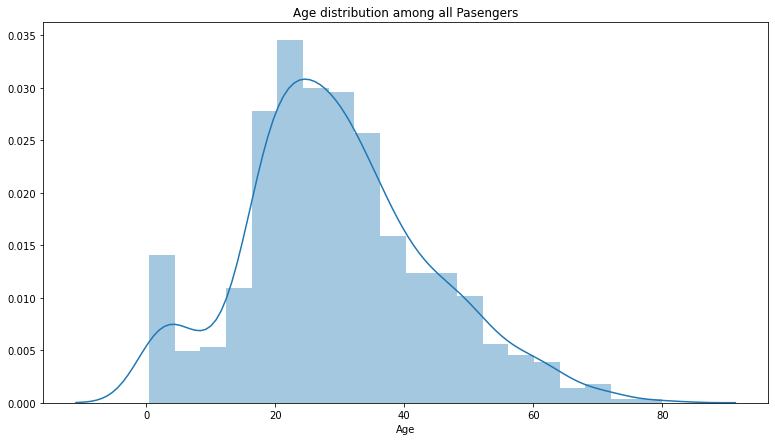

In [76]:
plt.figure(figsize=(13,7))
plt.title('Age distribution among all Pasengers')
sns.distplot(pandas_dftt['Age']);

#### Passengers Survival Scenario

##### According to Age

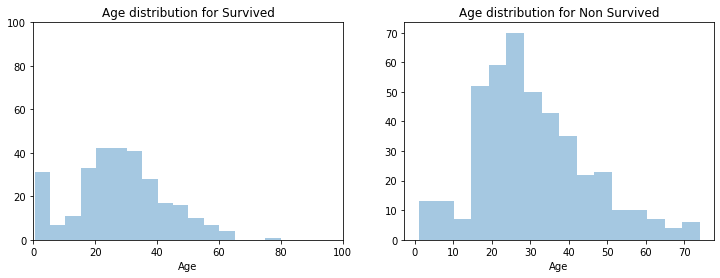

In [77]:
plt.subplot(1,2,1)
#plt.figure(figsize=(25,10))
plt.title('Age distribution for Survived')
plt.axis([0,100,0,100])
sns.distplot(pandas_dftt[pandas_dftt.Survived == 1]['Age'],kde=False)

plt.subplot(1,2,2)
plt.title('Age distribution for Non Survived')
sns.distplot(pandas_dftt[pandas_dftt.Survived == 0]['Age'],kde=False)

plt.subplots_adjust(right=1.7)
plt.show()

##### According to Gender

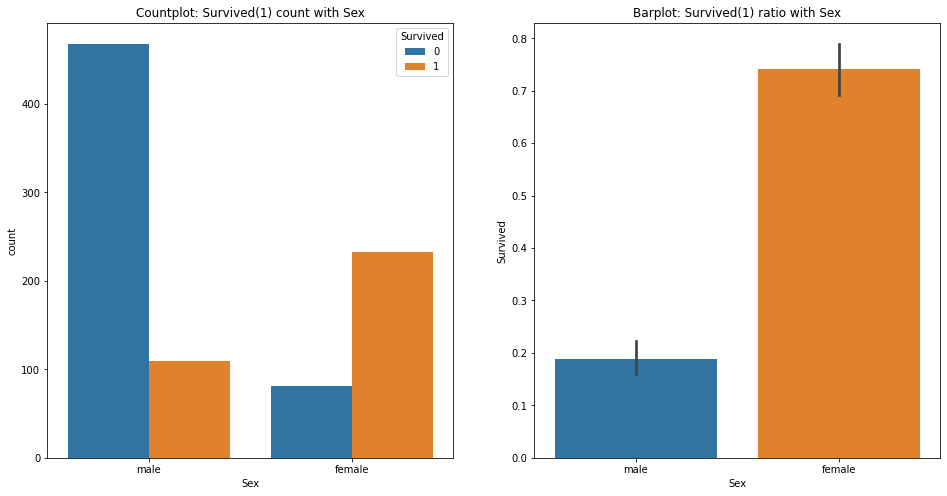

In [78]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].set_title('Countplot: Survived(1) count with Sex')
sns.countplot(x=pandas_dftt['Sex'],hue= pandas_dftt['Survived'],ax=ax[0])

ax[1].set_title('Barplot: Survived(1) ratio with Sex')
sns.barplot(pandas_dftt['Sex'], pandas_dftt['Survived'],ax=ax[1])

### Data Cleaning

In [79]:
# Because Cabin column has a lot missing value ( > 50%) so we can remove it
dftt = dftt.drop("Cabin")

In [80]:
dftt = dftt.withColumn("Initial",regexp_extract(col("Name"),"([A-Za-z]+)\.",1))
dftt.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr


In [81]:
# There are some misspelled Initials like Mlle or Mme that stand for Miss. we will replace them with Miss and same thing for other values.
dftt = dftt.replace(['Mlle','Mme', 'Ms', 'Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
                        ['Miss','Miss','Miss','Mr','Mr',  'Mrs',  'Mrs',  'Other',  'Other','Other','Mr','Mr','Mr'])

# Checking the average age by Initials
dftt.groupby('Initial').avg('Age').collect()

[Row(Initial='Miss', avg(Age)=21.86),
 Row(Initial='Other', avg(Age)=45.888888888888886),
 Row(Initial='Master', avg(Age)=4.574166666666667),
 Row(Initial='Mr', avg(Age)=32.73960880195599),
 Row(Initial='Mrs', avg(Age)=35.981818181818184)]

In [82]:
# Assigning missing values in age feature based on average age of Initials
dftt = dftt.withColumn("Age",when((dftt["Initial"] == "Miss")   & (dftt["Age"].isNull()), 22).otherwise(dftt["Age"]))
dftt = dftt.withColumn("Age",when((dftt["Initial"] == "Other")  & (dftt["Age"].isNull()), 46).otherwise(dftt["Age"]))
dftt = dftt.withColumn("Age",when((dftt["Initial"] == "Master") & (dftt["Age"].isNull()), 5).otherwise( dftt["Age"]))
dftt = dftt.withColumn("Age",when((dftt["Initial"] == "Mr")     & (dftt["Age"].isNull()), 33).otherwise(dftt["Age"]))
dftt = dftt.withColumn("Age",when((dftt["Initial"] == "Mrs")    & (dftt["Age"].isNull()), 36).otherwise(dftt["Age"]))


In [83]:
# Embarked columns has two missing values, let check it
dftt.groupBy("Embarked").count().show()

+--------+-----+
|Embarked|count|
+--------+-----+
|       Q|   77|
|    null|    2|
|       C|  168|
|       S|  644|
+--------+-----+



In [84]:
# As we can see, Majority Passengers boarded from "S". We can assign missing value with "S"
dftt = dftt.na.fill({"Embarked" : 'S'})
# Check again the missing value status
dftt.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in dftt.columns]).show()

+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|PassengerId|Survived|Pclass|Name|Sex|Age|SibSp|Parch|Ticket|Fare|Embarked|Initial|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+
|          0|       0|     0|   0|  0|  0|    0|    0|     0|   0|       0|      0|
+-----------+--------+------+----+---+---+-----+-----+------+----+--------+-------+



In [85]:
dftt = dftt.withColumn("Family_Size",col('SibSp')+col('Parch')) # Create new column: Family_size
dftt = dftt.withColumn('Alone',lit(0))  # Create new column: Alone and assign 0 default value to Alone column
dftt = dftt.withColumn("Alone",when(dftt["Family_Size"] == 0, 1).otherwise(dftt["Alone"]))

# converting Sex, Embarked & Initial columns from string to number using StringIndexer
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(dftt) for column in ["Sex","Embarked","Initial"]]
pipeline = Pipeline(stages=indexers)
dftt = pipeline.fit(dftt).transform(dftt)
dftt.limit(5).toPandas()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Initial,Family_Size,Alone,Sex_index,Embarked_index,Initial_index
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,Mr,1,0,0.0,0.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,Mrs,1,0,1.0,1.0,2.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,Miss,0,1,1.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,Mrs,1,0,1.0,0.0,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,Mr,0,1,0.0,0.0,0.0


In [86]:
# Now we drop columns that not needed for modelling
dftt = dftt.drop("PassengerId","Name","Ticket","Cabin","Embarked","Sex","Initial")

# Before modelling in Pyspark, we need to put all features to Vector using Pyspark VectorAssembler
feature = VectorAssembler(inputCols = dftt.columns[1:],outputCol="features")
feature_vector= feature.transform(dftt)
feature_vector.limit(5).toPandas()

,Survived,Pclass,Age,SibSp,Parch,Fare,Family_Size,Alone,Sex_index,Embarked_index,Initial_index,features
0,0,3,22.0,1,0,7.2500,1,0,0.0,0.0,0.0,"(3.0, 22.0, 1.0, 0.0, 7.25, 1.0, 0.0, 0.0, 0.0..."
1,1,1,38.0,1,0,71.2833,1,0,1.0,1.0,2.0,"[1.0, 38.0, 1.0, 0.0, 71.2833, 1.0, 0.0, 1.0, ..."
2,1,3,26.0,0,0,7.9250,0,1,1.0,0.0,1.0,"[3.0, 26.0, 0.0, 0.0, 7.925, 0.0, 1.0, 1.0, 0...."
3,1,1,35.0,1,0,53.1000,1,0,1.0,0.0,2.0,"[1.0, 35.0, 1.0, 0.0, 53.1, 1.0, 0.0, 1.0, 0.0..."
4,0,3,35.0,0,0,8.0500,0,1,0.0,0.0,0.0,"(3.0, 35.0, 0.0, 0.0, 8.05, 0.0, 1.0, 0.0, 0.0..."


#### SHAPE

In [87]:
#Converting into Pandas DataFrame
pandas_dftt = dftt.toPandas()
pandas_dftt.shape

(891, 11)

#### Generating Correlations 

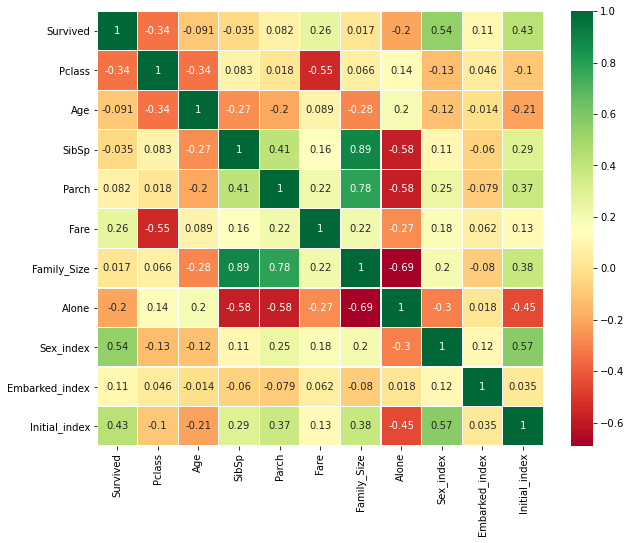

In [88]:
sns.heatmap(pandas_dftt.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

# Task I.2 : Recommendation using Movie Ratings Data

### Alternative Least Squares(ALS)

In [89]:
# split the data into training and test datatset
train, test = df_mv.randomSplit([0.75,0.25])
from pyspark.ml.recommendation import ALS

#Training the recommender model using train datatset
rec=ALS( maxIter=10
        ,regParam=0.01
        ,userCol='critic_index'
        ,itemCol='title_index'
        ,ratingCol='rating'
        ,nonnegative=True
        ,coldStartStrategy="drop")

#fit the model on train set
rec_model=rec.fit(train)

#making predictions on test set 
predicted_ratings=rec_model.transform(test)
predicted_ratings.limit(5).toPandas()

,critic,title,rating,title_index,critic_index,prediction
0,Jack Matthews,Superman Returns,5.0,1.0,4.0,4.225003
1,Gene Seymour,The Night Listener,3.0,3.0,0.0,3.667831
2,Lisa Rose,Lady in the Water,2.5,5.0,1.0,2.333113
3,Mick LaSalle,Just My Luck,2.0,4.0,2.0,2.456398
4,Gene Seymour,Just My Luck,1.5,4.0,0.0,2.974801


In [90]:
# First we need to create dataset of all distinct movies 
unique_movies=df_mv.select('title_index').distinct()

#create function to recommend top 'n' movies to any particular user
def top_movies(critic_index,n):
  
    #assigning alias name 'a' to unique movies df
    a = unique_movies.alias('a')
    
    #creating another dataframe which contains already watched movie by active user 
    watched_movies=df_mv.filter(df_mv['critic_index'] == critic_index).select('title_index')
    
    #assigning alias name 'b' to watched movies df
    b=watched_movies.alias('b')
    
    #joining both tables on left join 
    total_movies = a.join(b, a.title_index == b.title_index,how='left')
    
    #selecting movies which active user is yet to rate or watch
    remaining_movies=total_movies.where(col("b.title_index").isNull()).select(a.title_index).distinct()
    
    
    #adding new column of user_Id of active useer to remaining movies df 
    remaining_movies=remaining_movies.withColumn("critic_index",lit(int(critic_index)))
    
    
    #making recommendations using ALS recommender model and selecting only top 'n' movies
    recommendations=rec_model.transform(remaining_movies).orderBy('prediction',ascending=False).limit(n)
    
    
    #adding columns of movie titles in recommendations
    movie_title = IndexToString(inputCol="title_index", outputCol="title")
    final_recommendations=movie_title.transform(recommendations)
    
    #return the recommendations to active user
    return final_recommendations.show(n,False)

In [91]:
# Test: recommend movies for user of critic_index=3
top_movies(3,3)

+-----------+------------+----------+-----------------+
|title_index|critic_index|prediction|title            |
+-----------+------------+----------+-----------------+
|5.0        |3           |2.7118502 |Lady in the Water|
+-----------+------------+----------+-----------------+



### Evaluation : MSE

In [92]:
# Importing Regression Evaluator to measure MSE
from pyspark.ml.evaluation import RegressionEvaluator
# create Regressor evaluator object for measuring accuracy
evaluator=RegressionEvaluator(metricName='mse',predictionCol='prediction',labelCol='rating')
# apply the RE on predictions dataframe to calculate MSE
mse=evaluator.evaluate(predicted_ratings)
# print MSE error
print(mse)

0.5791645252760796


# Task I.3 : Classification on Titanic Dataset

### Logistic Regression

In [97]:
# Select features column for features training and 'Survived' as label to predict
titanic_df = feature_vector.select(['features','Survived'])
# Split the dataset to train_df and test_df
train_df,test_df = titanic_df.randomSplit([0.75,0.25])

In [98]:
# Load PySpark Libraries
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import roc_curve,auc

# Define Algorithm
lr = LogisticRegression(labelCol="Survived")

# Define Grid Parameters
paramGrid = ParamGridBuilder().addGrid(lr.regParam, (0.01, 0.1))\
                              .addGrid(lr.maxIter, (5, 10))\
                              .addGrid(lr.tol, (1e-4, 1e-5))\
                              .addGrid(lr.elasticNetParam, (0.25,0.75))\
                              .build()

# Define Cross Validation With Parameters
tvs = TrainValidationSplit( estimator=lr
                           ,estimatorParamMaps=paramGrid
                           ,evaluator=MulticlassClassificationEvaluator(labelCol='Survived')
                           ,trainRatio=0.8)
model = tvs.fit(train_df)
model_predictions= model.transform(test_df)

print('Accuracy: ', MulticlassClassificationEvaluator(labelCol='Survived',metricName='accuracy').evaluate(model_predictions))
print('Precision: ',MulticlassClassificationEvaluator(labelCol='Survived',metricName='weightedPrecision').evaluate(model_predictions))

Accuracy:  0.8409090909090909
Precision:  0.8425892857142857


### Evaluation: ROC & AUC

In [99]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics as metric
from pyspark import SparkContext
sc =SparkContext.getOrCreate()   # We need to create SparkContext
results = model_predictions.select(['probability', 'Survived'])
 
# Prepare score-label set
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]
scoreAndLabels = sc.parallelize(results_list)
 
metrics = metric(scoreAndLabels)
print("The ROC score is : ", metrics.areaUnderROC)

The ROC score is :  0.8959676686949413


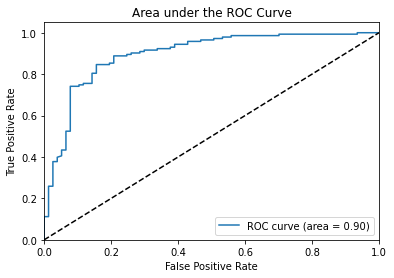

In [100]:
from sklearn.metrics import roc_curve, auc
 
fpr = dict()
tpr = dict()
roc_auc = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
 
%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area under the ROC Curve')
plt.legend(loc="lower right")
plt.show()